<a href="https://colab.research.google.com/github/tsintermax/colab/blob/main/%E5%8F%AF%E8%A6%96%E5%8C%96Cup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 下準備

In [ ]:
from sklearn import datasets
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector as selector
import lightgbm as lgb
import numpy as np
import pandas as pd

In [ ]:
original = pd.read_csv("http://www.minethatdata.com/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv")
df = original.drop(["visit", "spend"], axis=1)
categorycal_cols = selector(dtype_include="object")(df)
df[categorycal_cols] = df[categorycal_cols].astype("category")

X = df.drop('conversion', axis=1)
y = df['conversion']

# X, y = datasets.make_classification(n_samples=500000, n_features=20,
#                                     n_informative=2, n_redundant=10,
#                                     random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

In [ ]:
# model = CalibratedClassifierCV(lgb.LGBMClassifier(), cv=5, method='isotonic')
model = lgb.LGBMClassifier()
model.fit(X_train, y_train)
y_proba =  model.predict_proba(X_test)[:, 1]

# タスク1 Calibration Curve

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.4)
_FIGSIZE = (12, 7)

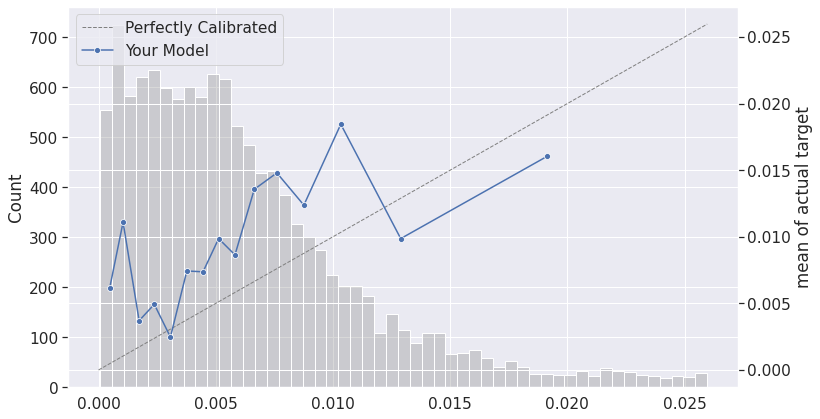

In [ ]:
fig, ax = plt.subplots(figsize=_FIGSIZE)
n_bins = 15
strategy = "quantile"
upper_bound = np.quantile(y_proba, 0.95)
bounded_y_proba = [s for s in y_proba if s < upper_bound]
bounded_y_true = [t for t, s in zip(y_test, y_proba) if s < upper_bound]
y_means, proba_means = calibration_curve(bounded_y_true, bounded_y_proba, n_bins=n_bins, strategy=strategy,)
sns.histplot(bounded_y_proba, ax=ax, color="grey", alpha=0.3)

ax2 = ax.twinx()
df = pd.DataFrame({"mean of actual target": y_means, "mean of predicted probability": proba_means})
sns.lineplot(x=[0, upper_bound], y=[0, upper_bound], ax=ax2, lw=1, label="Perfectly Calibrated")
sns.lineplot(data=df, x="mean of predicted probability", y="mean of actual target", ax=ax2, label="Your Model")

ax2.lines[0].set_linestyle("--")
ax2.lines[0].set_color("gray")
ax2.lines[1].set_marker("o")
ax2.lines[1].set_color("b")
plt.legend()

# タスク2 Feature Importance

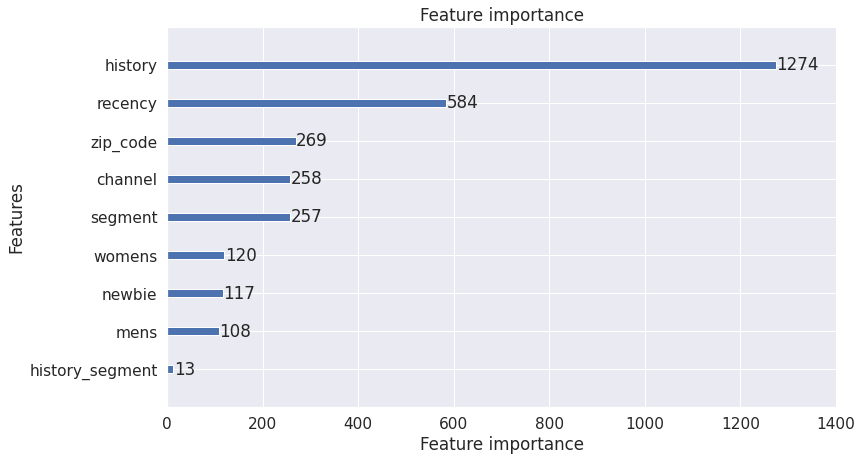

In [ ]:
## 簡単なやつ
fig = plt.figure(figsize=_FIGSIZE)
ax = fig.add_subplot(1, 1, 1)
lgb.plot_importance(booster=model, ax=ax, importance_type='split')

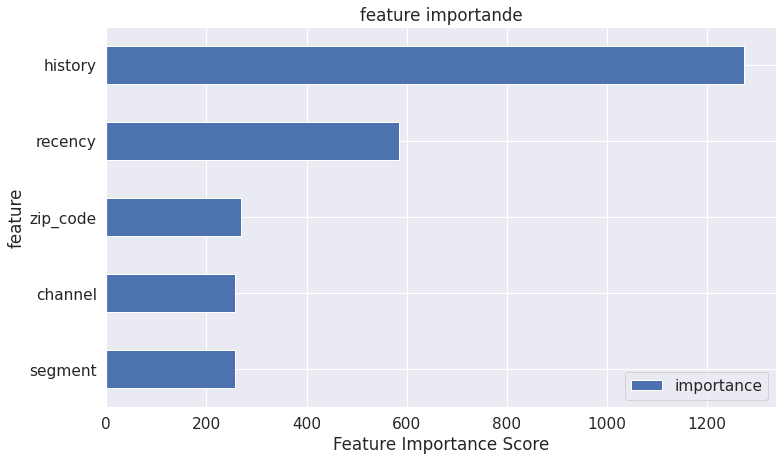

In [ ]:
## matplotlib
pd.options.plotting.backend = "matplotlib"
importance_df = pd.DataFrame({'importance':model.feature_importances_,
                         'feature' : X_train.columns
                         })    
importance_df.sort_values(by='importance', ascending=True, inplace=True)
topn = 5 
importance_df = importance_df.iloc[-topn:]
importance_df.plot.barh(x='feature',y='importance', title="feature importande", figsize=_FIGSIZE)
plt.xlabel('Feature Importance Score')
plt.show()

In [ ]:
!pip install --upgrade plotly

Requirement already up-to-date: plotly in /usr/local/lib/python3.7/dist-packages (4.14.3)


In [ ]:
## plotly
pd.options.plotting.backend = "plotly"
importance_df = pd.DataFrame({'importance':model.feature_importances_,
                         'feature' : X_train.columns
                         })    
importance_df.sort_values(by='importance', ascending=True, inplace=True)
topn = 5 
importance_df = importance_df.iloc[-topn:]
importance_df.set_index('feature', drop=True, inplace=True)
importance_df.plot.barh(x='importance')

[Text(0, 0.5, 'Importance'), Text(0.5, 0, 'Columns')]

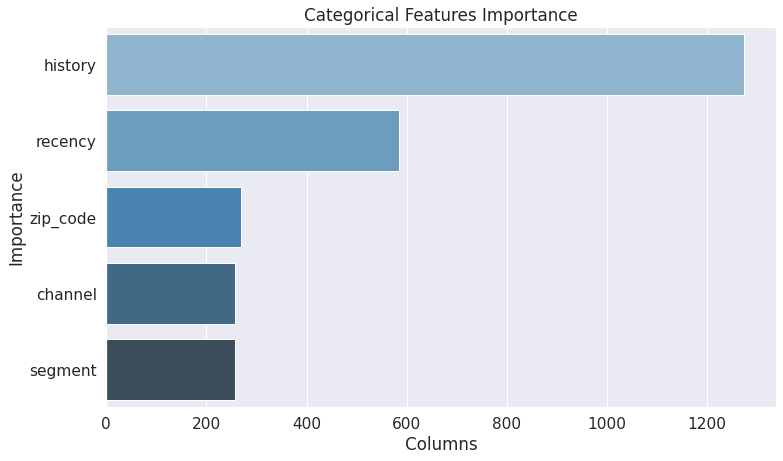

In [ ]:
## seaborn
importance_df = pd.DataFrame({'importance':model.feature_importances_,
                         'feature' : X_train.columns
                         })    
importance_df.sort_values(by='importance', ascending=True, inplace=True)
topn = 5 
importance_df = importance_df.iloc[-topn:]
importance_df.sort_values(by='importance',inplace=True,ascending=False)

fig, ax = plt.subplots(figsize=_FIGSIZE)

sns.barplot(data=importance_df,y='feature', x='importance',\
label="Feature Importance", palette=("Blues_d"),ax=ax, orient='h').\
set_title('Features Importance')

ax.set(xlabel="Columns", ylabel = "Importance")